In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Dense, Flatten, Conv1D, GlobalMaxPool1D, Input, concatenate, MaxPooling1D, GlobalMaxPooling1D, MaxPool1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import nltk
import json
import re
import os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df_restaurant = pd.read_csv('/content/drive/MyDrive/seminar/yelp_restaurant_only.csv')
print(df_restaurant.shape)
df_restaurant.head()

(4724686, 22)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,0.0,0.0,1.0,This is nice little Chinese bakery in the hear...,2014-05-26 01:09:53
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,3.0,1.0,2.0,This is the bakery I usually go to in Chinatow...,2013-10-05 15:19:06
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,0.0,0.0,0.0,"A delightful find in Chinatown! Very clean, an...",2013-10-25 01:34:57
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,5.0,0.0,5.0,I ordered a graduation cake for my niece and i...,2018-05-20 17:58:57
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",D1GisLDPe84Rrk_R4X2brQ,EouCKoDfzaVG0klEgdDvCQ,4.0,2.0,1.0,1.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,2013-10-25 02:31:35


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


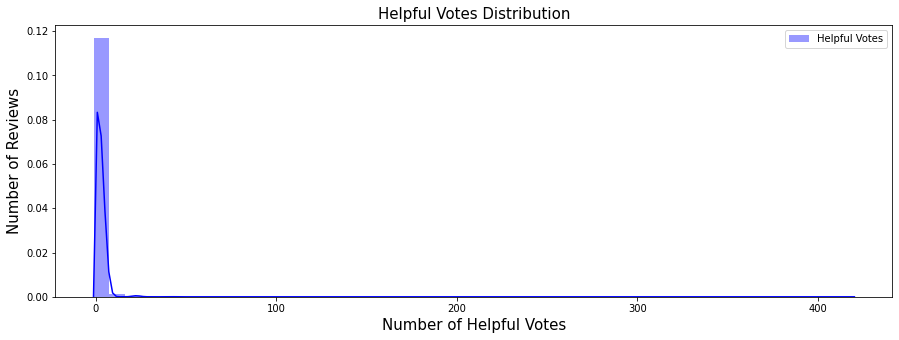

최대 Helpful Votes 수 :  420.0
평균 Helpful Votes 수 :  0.98
상위 75% Helpful Votes 수 :  1.0


In [ ]:
# helpful votes distribution
def helpful_dist(df=None):
  plt.figure(figsize=(15,5))
  sns.distplot(df['useful'], bins=50, color='b', label='Helpful Votes')
  plt.title('Helpful Votes Distribution',fontsize=15)
  plt.legend()
  plt.xlabel('Number of Helpful Votes', fontsize=15)
  plt.ylabel('Number of Reviews', fontsize=15)
  plt.show()

  print('최대 Helpful Votes 수 : ', df['useful'].max())
  print('평균 Helpful Votes 수 : ', np.round(df['useful'].mean(),2))
  print('상위 75% Helpful Votes 수 : ', df['useful'].quantile(q=0.75))

helpful_dist(df_restaurant)

In [ ]:
def is_helpful(x):
  if x >= 4:
    x=1

  else: 
    x=0
  return x

def df_preprocessing(df=None):
  df = df[(df['useful'] == 0) | (df['useful'] >= 4)]
  df['is_helpful'] = df['useful'].apply(lambda x: is_helpful(x))
  df.drop(columns=['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_x', 
                   'review_count', 'is_open', 'attributes', 'categories', 'hours', 'review_id',
                   'user_id', 'stars_y', 'funny', 'cool', 'date'], inplace=True)
  df = df[(df['is_helpful'] == 0) | (df['is_helpful'] == 1)]
  return df

df_restaurant_2 = df_preprocessing(df_restaurant)
print(df_restaurant_2['is_helpful'].value_counts())
df_restaurant_2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0    2755331
1     294725
Name: is_helpful, dtype: int64


,useful,text,is_helpful
0,0.0,This is nice little Chinese bakery in the hear...,0
2,0.0,"A delightful find in Chinatown! Very clean, an...",0
3,5.0,I ordered a graduation cake for my niece and i...,1
6,0.0,so I dropped in to this store since it was the...,0
8,0.0,Best egg tarts? \n\nI was lucky to get them fr...,0


In [ ]:
'''
# df_preprocessing
# is_helpful 이름으로 Label 생성
# is_helpful 기준 : helpfulness >=4
# 근거 논문 : Effectiveness of Fine-Tuned ~(2022) --> 8.10 폴더 참조

def make_is_helpful(x):
  if x >= 4:
    x=1
  else: 
    x=0
  return x

def df_preprocessing(df=None):
  df['is_helpful'] = df['useful'].apply(lambda x: make_is_helpful(x))
  df.drop(columns=['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_x', 
                   'review_count', 'is_open', 'attributes', 'categories', 'hours', 'review_id',
                   'user_id', 'stars_y', 'funny', 'cool', 'date'], inplace=True)

  return df

df_restaurant_2 = df_preprocessing(df_restaurant)
print(df_restaurant_2['is_helpful'].value_counts())
df_restaurant_2.head()
'''

0    4429961
1     294725
Name: is_helpful, dtype: int64


,useful,text,is_helpful
0,0.0,This is nice little Chinese bakery in the hear...,0
1,3.0,This is the bakery I usually go to in Chinatow...,0
2,0.0,"A delightful find in Chinatown! Very clean, an...",0
3,5.0,I ordered a graduation cake for my niece and i...,1
4,2.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,0


# 1. Text Preprocessing & Data Splitting

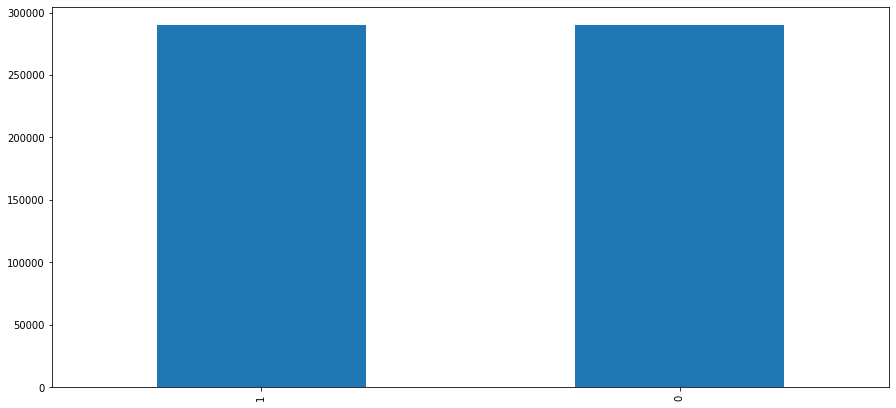

In [ ]:
# Sampling
# is_helpful : 1 --> sample_size    /    is_helpful : 0 --> sample_size
# seed값은 42로 고정
# Train_test_split하기 전 Text Preprocessing

def sampling(sample_size, df=None):
  '''
  sample_size만큼 helpful_df & unhelpful_df에서 데이터 샘플 추출
  전체 추출되는 Data Size = 2 * sample_size
  '''
  helpful_df = df[df['is_helpful'] == 1]
  unhelpful_df = df[df['is_helpful'] == 0]
  helpful_samples = helpful_df.sample(n=sample_size, random_state=42) 
  unhelpful_samples = unhelpful_df.sample(n=sample_size, random_state=42)

  df_samples = pd.concat([helpful_samples, unhelpful_samples])
  return df_samples
  

def split_variables(sample_size, df=None):
  '''
  X = label을 제외한 나머지 컬럼들(리뷰 텍스트 포함)
  y = label  (is_helpful)
  '''
  df_samples = sampling(sample_size, df)
  X = df_samples.drop(columns='is_helpful', inplace=False)
  y = df_samples['is_helpful']
  return X, y

X, y = split_variables(290000, df_restaurant_2)

plt.figure(figsize=(15,7))
y.value_counts().plot(kind='bar')
plt.show()

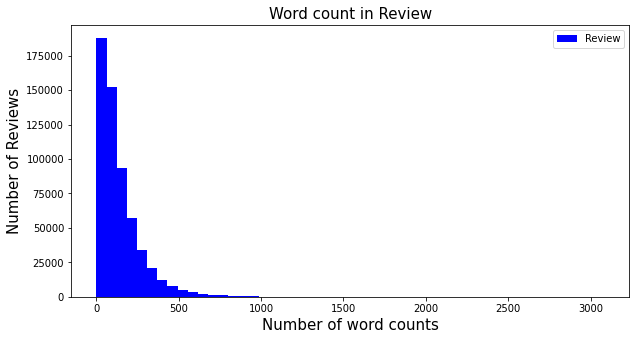

리뷰 단어 개수 최댓값 : 3079
리뷰 단어 개수 최소값 : 1
리뷰 단어 개수 평균값 : 140.56436896551725
리뷰 단어 개수 상위 90%값 : 304.0


In [ ]:
# 리뷰 내 단어 개수 카운트
def check_word_count(df=None):
  train_word_count = df['text'].apply(lambda x: len(x.split(' ')))
  
  plt.figure(figsize=(10,5))
  plt.hist(train_word_count, bins=50, color='b', label='Review')
  plt.title('Word count in Review',fontsize=15)
  plt.legend()
  plt.xlabel('Number of word counts', fontsize=15)
  plt.ylabel('Number of Reviews', fontsize=15)
  plt.show()


  print(f'리뷰 단어 개수 최댓값 : {np.max(train_word_count)}')
  print(f'리뷰 단어 개수 최소값 : {np.min(train_word_count)}')
  print(f'리뷰 단어 개수 평균값 : {np.mean(train_word_count)}')
  print(f'리뷰 단어 개수 상위 90%값 : {np.percentile(train_word_count, 90)}')

check_word_count(X)

In [ ]:
# Text Preprocessing --> Data Splitting 하기 전 수행
# 논문 프로세스를 따름 : 소문자 변환 --> BeautifulSoup로 url 태그 제거 --> 구두점 등 특수문자 제거(정규표현식) --> 길이는 몇으로 padding? 
# 근거 논문 : Unboxing DL Model of food ~ (2022) --> 8.3 폴더 참조
# 근거 논문은 Review_length를 100으로 결정했음(따로 이유는 안나옴)
# 일단 해당 논문을 따라 100으로 max_len길이 맞춤


tokenizer = Tokenizer()
max_len = 304

def word_preprocessing(df=None, remove_stopwords=False):
  '''
  논문 프로세스를 따름 : 소문자 변환 --> Bs4로 url 태그 제거 --> 구두점 등 특수문자 제거(정규표현식) 
                    --> 길이는 논문따라 100으로 padding(max_len)
  
  remove_stopwords=False
  --> True로 재설정 시 불용어 제거 과정 추가됨
  '''

  train_review = df['text']
  processed_text = []

  for review in train_review:
    review_text = BeautifulSoup(review, 'html5lib').get_text()
    review_text = re.sub('[^a-zA-Z0-9]', ' ', review_text)
    words = review_text.lower().split()

    if remove_stopwords:
      stop_words = set(stopwords.words('english'))
      words = [w for w in words if not w in stop_words]
      clean_review = ' '.join(words)
    
    else:
      clean_review = ' '.join(words)
    
    processed_text.append(clean_review)

  return processed_text


def tokenizing(tokenizer,df=None):
  '''
  전처리 완료된 processed_text를 불러와
  토큰화 및 각 토큰에 대해 정수 인코딩
  padding처리 된 부분 --> <PAD> 토큰 부여 및 0으로 값 지정
  '''
  processed_text = word_preprocessing(df, remove_stopwords=True)
  tokenizer.fit_on_texts(processed_text)
  text_sequences = tokenizer.texts_to_sequences(processed_text)

  word_vocab = tokenizer.word_index
  word_vocab['<PAD>'] = 0

  return text_sequences, word_vocab


def text_padding(max_len,df=None):
  '''
  text sequence의 길이 통일
  '''
  text_sequences, word_vocab = tokenizing(tokenizer,df)
  text_inputs = pad_sequences(text_sequences, maxlen=max_len, padding='post')
  print(f'shape of train_data : {text_inputs.shape}')

  return text_inputs, word_vocab


text_inputs, word_vocab = text_padding(max_len, X)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.delawareonline.com/story/news/health/2019/09/10/restaurant-closed-state-after-dead-dying-and-live-roaches-found-official/2263561001/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


shape of train_data : (580000, 304)


In [ ]:
data_configs = dict()
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

np.save(open('inputs_2.npy','wb'), text_inputs)
np.save(open('labels_2.npy','wb'), np.array(y))
json.dump(data_configs, open('data_configs_2.json','w'),ensure_ascii=False)

In [ ]:
inputs = np.load(open('/content/drive/MyDrive/inputs_2.npy','rb'))
labels = np.load(open('/content/drive/MyDrive/labels_2.npy','rb'))
prepro_configs = json.load(open('/content/drive/MyDrive/data_configs_2.json','r'))

In [ ]:
prepro_configs['vocab_size']

178732

In [ ]:
# Data Splitting

def split_data(inputs, labels, test_size):

  X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=test_size, shuffle=True, random_state=42, stratify=labels)

  return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = split_data(text_inputs,0.2)
X_train, X_test, y_train, y_test = split_data(inputs, labels, 0.2)
print(f'X_train 크기 : {len(X_train)}','\t',f'X_test 크기 : {len(X_test)}','\n')

X_train 크기 : 464000 	 X_test 크기 : 116000 



  # 2. Compare Models(Test Data 기준)
### acc / f1_score / precision / recall 순

* CNN(single) : 0.6932 / 0,7426 / 0.6397 / 0.8849
* CNN(multi) : 0.6963 / 0.7441 / 0.6429 / 0.8833
* LSTM : 0.7366 / 0.7398 / 0.7310 / 0.7486
* CNN-LSTM(single) : 0.7271 / 0.7136 / 0.7507 / 0.6800
* CNN-LSTM(multi) : 0.7269 / 0.7298 / 0.7222 / 0.7376
* SVM : 0.4897 / 0.6536 / 0.4947 / 0.9628
* RF : 0.7183 / 0.7217 / 0.713 / 0.7306
* NB : 0.5904 / 0.3614 / 0.8197 / 0.2318

In [ ]:
# metrics 추가 --> Precision, Recall, F1-Score

def recall_m(y_true, y_pred):
  '''
  y_true_yn / y_pred_yn --> 실제값 또는 예측값을 1 또는 0으로 설정
  count_tp --> 실제값과 예측값이 모두 1인 경우(tp)
  count_tp_fn --> 실제 값이 1인 전체(tp+fn)
  K.epsilon --> count_tp_fn의 값이 0인 경우 대비 매우 작은 수를 더함
  '''
  y_true_yn = K.round(K.clip(y_true, 0, 1))
  y_pred_yn = K.round(K.clip(y_pred, 0, 1))

  count_tp = K.sum(y_true_yn * y_pred_yn)
  count_tp_fn = K.sum(y_true_yn)

  recall = count_tp / (count_tp_fn + K.epsilon()) 
  
  return recall


def precision_m(y_true, y_pred):
  '''
  count_tp --> 실제값과 예측값이 모두 1인 경우(tp)
  count_tp_fp --> 예측값을 1로 한 경우(tp+fp)
  '''
  y_true_yn = K.round(K.clip(y_true, 0, 1))
  y_pred_yn = K.round(K.clip(y_pred, 0, 1))

  count_tp = K.sum(y_true_yn * y_pred_yn)
  count_tp_fp = K.sum(y_pred_yn)

  precision = count_tp / (count_tp_fp + K.epsilon())

  return precision

def f1_m(y_true, y_pred):
  recall = recall_m(y_true, y_pred)
  precision = precision_m(y_true, y_pred)
  f1_score = (2 * recall * precision) / (recall + precision + K.epsilon())
  return f1_score

In [ ]:
# Set Seed
# numpy와 tensorflow 2가지에 seed 설정
# 해당 코드 출처 : https://dacon.io/codeshare/2363

def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
  tf.random.set_seed(seed)
my_seed = 42
seed_everything(my_seed)

In [ ]:
# CNN-1D 모델 - Single Kernel Size(3)

kargs = {'model_name' : 'cnn_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.2, 'num_filters' : 100, 'kernel_size' : 3, 'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

# num_filters --> 256 --> 100으로 수정함

class CNN(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNN, self).__init__(name=kargs['model_name'])

    self.embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')

    self.cnn = Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size'], padding='valid', 
                      activation='relu', name='cnn_layer')
    
    self.pooling = GlobalMaxPool1D()
    self.dropout = Dropout(kargs['dropout_rate'], name='dropout_layer')
    self.flatten = Flatten()
    self.fc_1 = Dense(kargs['dense_dim_1'], activation=relu, name='dense_layer_1')
    self.fc_2 = Dense(kargs['dense_dim_2'], activation=relu, name='dense_layer_2')
    self.fc_3 = Dense(kargs['dense_dim_3'], activation=relu, name='dense_layer_3')
    self.output_layer = Dense(kargs['output_dim'], activation=sigmoid, name='output_layer')

  
  def call(self, inputs):
    x = self.embed(inputs)
    #x = self.dropout(x)
    x = self.cnn(x)
    x = self.pooling(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.fc_1(x)
    x = self.dropout(x)
    x = self.fc_2(x)
    #x = self.dropout(x)
    x = self.fc_3(x)
    x = self.output_layer(x)
    return x


model = CNN(**kargs)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m  
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='min')
cp = ModelCheckpoint('cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.build(input_shape=(1,304))
model.summary()

Model: "cnn_helpful_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     multiple                  53619600  
                                                                 
 cnn_layer (Conv1D)          multiple                  90100     
                                                                 
 global_max_pooling1d (Globa  multiple                 0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_layer (Dropout)     multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_layer_1 (Dense)       multiple                  12928     
                                            

Epoch 1/3
2000/2000 [==============================] - ETA: 0s - loss: 0.6275 - acc: 0.6397
Epoch 1: val_loss improved from inf to 0.57271, saving model to cnn_weights.h5
2000/2000 [==============================] - 113s 56ms/step - loss: 0.6275 - acc: 0.6397 - val_loss: 0.5727 - val_acc: 0.7041
Epoch 2/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5667 - acc: 0.7111
Epoch 2: val_loss did not improve from 0.57271
2000/2000 [==============================] - 111s 56ms/step - loss: 0.5667 - acc: 0.7111 - val_loss: 0.5948 - val_acc: 0.6934
Epoch 3/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5508 - acc: 0.7238
Epoch 3: val_loss did not improve from 0.57271
2000/2000 [==============================] - 112s 56ms/step - loss: 0.5508 - acc: 0.7238 - val_loss: 0.5947 - val_acc: 0.6971


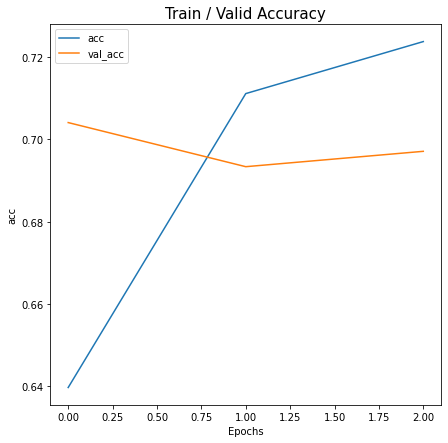

625/625 [==============================] - 4s 6ms/step - loss: 0.5981 - acc: 0.6932
[0.5980549454689026, 0.6932250261306763]
[0.7425628330466161]
[0.6396840887732235]
[0.884875]


In [ ]:
result = model.fit(X_train, y_train, batch_size=512, epochs=3, validation_split=0.2, callbacks=[es,cp])

# 모델 결과에 대해 시각화

def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'acc') 

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 304)]             0         
                                                                 
 embed_layer (Embedding)     (None, 304, 300)          53619600  
                                                                 
 cnn_layer (Conv1D)          (None, 302, 100)          90100     
                                                                 
 MaxPool1D (MaxPooling1D)    (None, 151, 100)          0         
                                                                 
 Flatten (Flatten)           (None, 15100)             0         
                                                                 
 drop_1 (Dropout)            (None, 15100)             0         
                                                                 
 FC_1 (Dense)                (None, 128)               193292

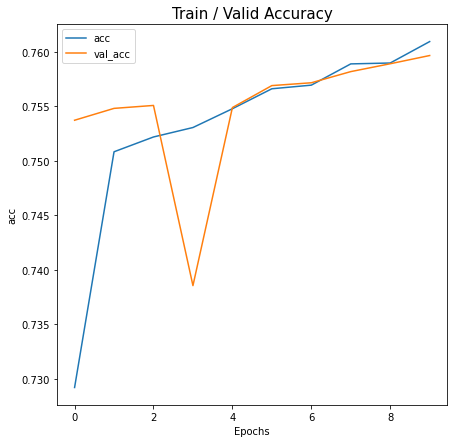

227/227 [==============================] - 5s 23ms/step - loss: 0.5083 - acc: 0.7604
[0.5083495378494263, 0.7603620886802673]
[0.760159445048403]
[0.7608027356567995]
[0.7595172413793103]


In [ ]:
# CNN-1D 모델_v2 - Single Kernel Size(3)

kargs = {'model_name' : 'cnn_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.2, 'num_filters' : 100, 'kernel_size' : 3, 'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

def single_cnn(**kargs):
  inputs = Input(shape=(304,))
  embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')(inputs)
  cnn = Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size'], padding='valid', 
                      activation='relu', name='cnn_layer')(embed)
  pool = MaxPooling1D(name='MaxPool1D')(cnn)
  flat = Flatten(name='Flatten')(pool)
  drop_1 = Dropout(kargs['dropout_rate'], name='drop_1')(flat) 
  fc_1 = Dense(kargs['dense_dim_1'], name='FC_1')(drop_1)
  drop_2 = Dropout(kargs['dropout_rate'], name='drop_2')(fc_1)
  fc_2 = Dense(kargs['dense_dim_2'], name='FC_2')(drop_2)
  fc_3 = Dense(kargs['dense_dim_3'], name='FC_3')(fc_2)
  output = Dense(kargs['output_dim'], name='output')(fc_3)
  return Model(inputs=inputs, outputs=output)

model = single_cnn(**kargs)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m  
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min')
cp = ModelCheckpoint('cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

result = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[es,cp])

# 모델 결과에 대해 시각화

def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'acc') 

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

In [ ]:
# CNN-1D 모델 - Multi Kernel Size

kargs = {'model_name' : 'cnn_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.2, 'num_filters' : 100, 'kernel_size' : 3, 'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

# num_filters --> 256 --> 100으로 수정함

class CNN(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNN, self).__init__(name=kargs['model_name'])

    self.embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')
    
    self.conv_list = [Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid',
                            activation=tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) 
                            for kernel_size in [3,4,5]  # 3개의 합성곱 레이어(커널 크기가 각각 3,4,5)를 한번에 묶었음
                      ]

    self.pooling = GlobalMaxPool1D()
    self.dropout = Dropout(kargs['dropout_rate'], name='dropout_layer')
    self.flatten = Flatten()
    self.fc_1 = Dense(kargs['dense_dim_1'], activation=relu, name='dense_layer_1')
    self.fc_2 = Dense(kargs['dense_dim_2'], activation=relu, name='dense_layer_2')
    self.fc_3 = Dense(kargs['dense_dim_3'], activation=relu, name='dense_layer_3')
    self.output_layer = Dense(kargs['output_dim'], activation=sigmoid, name='output_layer')

  
  def call(self, inputs):
    x = self.embed(inputs)
    #x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1) # 각각의 kernel 크기 다른 놈들을 같이 묶어주었음
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.fc_1(x)
    x = self.dropout(x)
    x = self.fc_2(x)
    x = self.dropout(x)
    x = self.fc_3(x)
    x = self.output_layer(x)
    return x


model = CNN(**kargs)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m  
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='min')
cp = ModelCheckpoint('cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.build(input_shape=(1,304))
model.summary()

Model: "cnn_helpful_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     multiple                  53619600  
                                                                 
 conv1d_9 (Conv1D)           multiple                  90100     
                                                                 
 conv1d_10 (Conv1D)          multiple                  120100    
                                                                 
 conv1d_11 (Conv1D)          multiple                  150100    
                                                                 
 global_max_pooling1d_4 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                                 
 dropout_layer (Dropout)     multiple                  0         
                                            

Epoch 1/3
2000/2000 [==============================] - ETA: 0s - loss: 0.6126 - acc: 0.6627
Epoch 1: val_loss improved from inf to 0.56657, saving model to cnn_weights.h5
2000/2000 [==============================] - 174s 86ms/step - loss: 0.6126 - acc: 0.6627 - val_loss: 0.5666 - val_acc: 0.7096
Epoch 2/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5638 - acc: 0.7128
Epoch 2: val_loss did not improve from 0.56657
2000/2000 [==============================] - 173s 86ms/step - loss: 0.5638 - acc: 0.7128 - val_loss: 0.5802 - val_acc: 0.7047
Epoch 3/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5500 - acc: 0.7246
Epoch 3: val_loss did not improve from 0.56657
2000/2000 [==============================] - 172s 86ms/step - loss: 0.5500 - acc: 0.7246 - val_loss: 0.5983 - val_acc: 0.6984


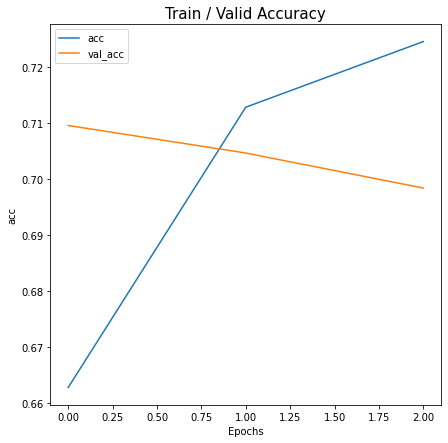

625/625 [==============================] - 9s 14ms/step - loss: 0.6012 - acc: 0.6963
[0.6011910438537598, 0.6963375210762024]
[0.7441738013247823]
[0.6428974326315982]
[0.883325]


In [ ]:
result = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.2, callbacks=[es,cp])

# 모델 결과에 대해 시각화

def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'acc') 

# X_test 데이터에 대해 검증

#cnn_model = model.load_weights('/content/cnn1d_weights.h5')
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, batch_size=128) 

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))
print(model.evaluate(X_test, y_test, batch_size=128))
print(f1_score_list)
print(precision_list)
print(recall_list)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304)]        0           []                               
                                                                                                  
 embed_layer (Embedding)        (None, 304, 300)     53619600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 304, 100)     90100       ['embed_layer[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 304, 100)     120100      ['embed_layer[0][0]']            
                                                                                              

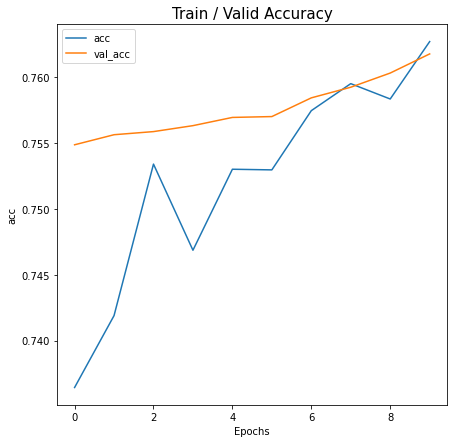

227/227 [==============================] - 8s 37ms/step - loss: 0.5085 - acc: 0.7618
[0.5084750056266785, 0.7617844939231873]
[0.762012212451878]
[0.7612844384023679]
[0.7627413793103448]


In [ ]:
# CNN-1D 모델_v2 - Multi Kernel Size 

kargs = {'model_name' : 'cnn_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.2, 'num_filters' : 100, 'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

def multi_cnn(**kargs):
  inputs = Input(shape=(304,))
  embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')(inputs)
  
  conv_1 = Conv1D(filters=kargs['num_filters'], kernel_size=3, padding='same', activation='relu')(embed)
  conv_1 = MaxPool1D()(conv_1)
  conv_2 = Conv1D(filters=kargs['num_filters'], kernel_size=4, padding='same', activation='relu')(embed)
  conv_2 = MaxPool1D()(conv_2)
  conv_3 = Conv1D(filters=kargs['num_filters'], kernel_size=5, padding='same', activation='relu')(embed)
  conv_3 = MaxPool1D()(conv_3) 
  
  concat = concatenate([conv_1, conv_2, conv_3], axis=-1, name='concate_layer')

  flat = Flatten(name='Flatten')(concat)
  drop_1 = Dropout(kargs['dropout_rate'], name='drop_1')(flat) 
  fc_1 = Dense(kargs['dense_dim_1'], name='FC_1')(drop_1)
  drop_2 = Dropout(kargs['dropout_rate'], name='drop_2')(fc_1)
  fc_2 = Dense(kargs['dense_dim_2'], name='FC_2')(drop_2)
  fc_3 = Dense(kargs['dense_dim_3'], name='FC_3')(fc_2)
  output = Dense(kargs['output_dim'], name='output')(fc_3)
  return Model(inputs=inputs, outputs=output)

model = multi_cnn(**kargs)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m  
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min')
cp = ModelCheckpoint('cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

result = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[es,cp])

# 모델 결과에 대해 시각화
def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'acc') 

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

In [ ]:
# LSTM 모델 투입

kargs = {'model_name' : 'lstm_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.2, 'lstm_dim' : 100, 'dense_dim_1' : 128, 'dense_dim_2' : 64, 
         'dense_dim_3' : 32, 'output_dim' : 1
         }

class LSTM(tf.keras.Model):

    def __init__(self, **kargs):
        super(LSTM, self).__init__(name=kargs['model_name'])

        self.embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')
        self.lstm_1 = layers.LSTM(kargs['lstm_dim'], return_sequences=True, name='lstm_layer_1')
        #self.lstm_2 = layers.LSTM(kargs['lstm_dim'], name='lstm_layer_2')
        self.dropout = Dropout(kargs['dropout_rate'], name='dropout')
        self.flatten = Flatten()
        self.fc_1 = Dense(kargs['dense_dim_1'], activation=relu, name='dense_layer_1')
        self.fc_2 = Dense(kargs['dense_dim_2'], activation=relu, name='dense_layer_2')
        self.fc_3 = Dense(kargs['dense_dim_3'], activation=relu, name='dense_layer_3')
        self.output_layer = Dense(kargs['output_dim'], activation=sigmoid, name='output_layer')

    def call(self, inputs):
        x = self.embed(inputs)
        #x = self.dropout(x)
        x = self.lstm_1(x)
        #x = self.lstm_2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc_1(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        x = self.dropout(x)
        x = self.fc_3(x)
        x = self.output_layer(x)
        return x

model = LSTM(**kargs)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min')
cp = ModelCheckpoint('lstm_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.build(input_shape=(1,304))
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "lstm_helpful_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     multiple                  53619600  
                                                                 
 lstm_layer_1 (LSTM)         multiple                  160400    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_layer_1 (Dense)       multiple                  3891328   
                                                                 
 dense_layer_2 (Dense)       multiple                  8256      
                                                                 
 dense_layer_3 (Dense)       multiple      

Epoch 1/10
725/725 [==============================] - ETA: 0s - loss: 0.5409 - acc: 0.7476
Epoch 1: val_loss improved from inf to 0.51466, saving model to lstm_weights.h5
725/725 [==============================] - 89s 121ms/step - loss: 0.5409 - acc: 0.7476 - val_loss: 0.5147 - val_acc: 0.7574
Epoch 2/10
725/725 [==============================] - ETA: 0s - loss: 0.5075 - acc: 0.7617
Epoch 2: val_loss improved from 0.51466 to 0.48919, saving model to lstm_weights.h5
725/725 [==============================] - 87s 121ms/step - loss: 0.5075 - acc: 0.7617 - val_loss: 0.4892 - val_acc: 0.7703
Epoch 3/10
725/725 [==============================] - ETA: 0s - loss: 0.4871 - acc: 0.7727
Epoch 3: val_loss improved from 0.48919 to 0.48194, saving model to lstm_weights.h5
725/725 [==============================] - 88s 121ms/step - loss: 0.4871 - acc: 0.7727 - val_loss: 0.4819 - val_acc: 0.7741
Epoch 4/10
725/725 [==============================] - ETA: 0s - loss: 0.4774 - acc: 0.7777
Epoch 4: val_los

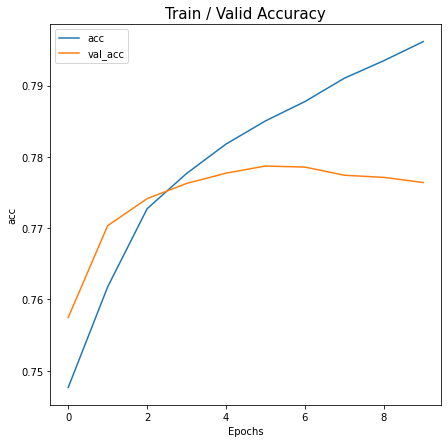

227/227 [==============================] - 7s 30ms/step - loss: 0.4813 - acc: 0.7744
[0.4812680184841156, 0.7744224071502686]
[0.7700109865963526]
[0.7853697893321381]
[0.7552413793103449]


In [ ]:
result = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[es,cp])
draw_plot(result, 'acc') 
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, batch_size=128)

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))
print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

In [ ]:
# CNN-LSTM 모델 - Single Kernel Size(3)
kargs = {'model_name' : 'cnn_lstm_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 
         'embed_dim' : 300, 'dropout_rate' : 0.2, 'lstm_dim' : 100, 'num_filters' : 100, 'kernel_size' : 3,
         'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

class CNN_LSTM(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNN_LSTM, self).__init__(name=kargs['model_name'])

    self.embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')

    self.cnn = Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size'], padding='valid', activation='relu', 
                     kernel_constraint=tf.keras.constraints.MaxNorm(max_value=0.1), name='cnn_layer')
    
    #self.pooling = GlobalMaxPool1D()
    self.lstm = layers.LSTM(kargs['lstm_dim'], name='lstm_layer')
    self.flatten = Flatten()
    self.dropout = Dropout(kargs['dropout_rate'])
    self.fc_1 = Dense(kargs['dense_dim_1'], activation=relu, name='dense_layer_1')
    self.fc_2 = Dense(kargs['dense_dim_2'], activation=relu, name='dense_layer_2')
    self.fc_3 = Dense(kargs['dense_dim_3'], activation=relu, name='dense_layer_3')
    self.output_layer = Dense(kargs['output_dim'],activation=sigmoid, name='output_layer')

  def call(self, inputs):
    x = self.embed(inputs)
    #x = self.dropout(x)
    x = self.cnn(x)
    #x = self.pooling(x)
    x = self.lstm(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.fc_1(x)
    x = self.dropout(x)
    x = self.fc_2(x)
    x = self.dropout(x)
    x = self.fc_3(x)
    x = self.output_layer(x)
    return x

model = CNN_LSTM(**kargs)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m
es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, mode='min')
cp = ModelCheckpoint('cnn_lstm_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.build(input_shape=(1,304))
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "cnn_lstm_helpful_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     multiple                  77764608  
                                                                 
 cnn_layer (Conv1D)          multiple                  196736    
                                                                 
 lstm_layer (LSTM)           multiple                  394240    
                                                                 
 flatten_14 (Flatten)        multiple                  0         
                                                                 
 dropout_56 (Dropout)        multiple                  0         
                                                                 
 dense_layer_1 (Dense)       multiple                  263168    
                                                                 
 dense_layer_2 (Dense)       multiple  

Epoch 1/3
2000/2000 [==============================] - ETA: 0s - loss: 0.6034 - acc: 0.6621
Epoch 1: val_loss improved from inf to 0.56259, saving model to cnn_lstm_weights.h5
2000/2000 [==============================] - 181s 89ms/step - loss: 0.6034 - acc: 0.6621 - val_loss: 0.5626 - val_acc: 0.7187
Epoch 2/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5603 - acc: 0.7190
Epoch 2: val_loss improved from 0.56259 to 0.55374, saving model to cnn_lstm_weights.h5
2000/2000 [==============================] - 179s 89ms/step - loss: 0.5603 - acc: 0.7190 - val_loss: 0.5537 - val_acc: 0.7238
Epoch 3/3
2000/2000 [==============================] - ETA: 0s - loss: 0.5481 - acc: 0.7291
Epoch 3: val_loss improved from 0.55374 to 0.55179, saving model to cnn_lstm_weights.h5
2000/2000 [==============================] - 179s 89ms/step - loss: 0.5481 - acc: 0.7291 - val_loss: 0.5518 - val_acc: 0.7269


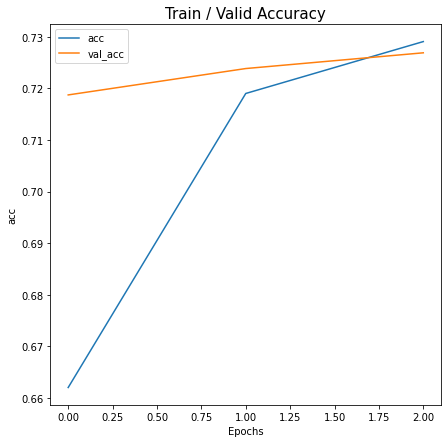

625/625 [==============================] - 11s 17ms/step - loss: 0.5534 - acc: 0.7271
[0.5533624887466431, 0.7270749807357788]
[0.7135773317591498]
[0.7507038365995031]
[0.67995]


In [ ]:
result = model.fit(X_train, y_train, batch_size=512, epochs=3, validation_split=0.2, callbacks=[es,cp])
draw_plot(result, 'acc') 
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, batch_size=128)

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))
print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 304)]        0           []                               
                                                                                                  
 embed_layer (Embedding)        (None, 304, 300)     53619600    ['input_3[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 304, 100)     90100       ['embed_layer[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 304, 100)     120100      ['embed_layer[0][0]']            
                                                                                            

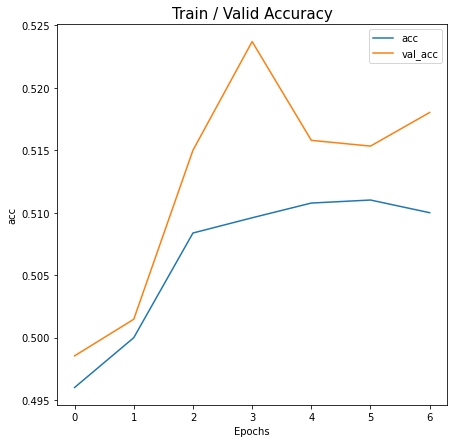

227/227 [==============================] - 21s 94ms/step - loss: 0.6894 - acc: 0.5194
[0.6894479990005493, 0.5194310545921326]
[0.07848712268985354]
[0.9518845228548516]
[0.04093103448275862]


In [ ]:
kargs = {'model_name' : 'cnn_lstm_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 
         'embed_dim' : 300, 'dropout_rate' : 0.2, 'lstm_dim' : 100, 'num_filters' : 100, 'kernel_size' : 3,
         'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

def single_cnn_lstm(**kargs):
  inputs = Input(shape=(304,))
  embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')(inputs)
  
  conv_1 = Conv1D(filters=kargs['num_filters'], kernel_size=3, padding='same', activation='relu')(embed)
  conv_2 = Conv1D(filters=kargs['num_filters'], kernel_size=4, padding='same', activation='relu')(embed)
  conv_3 = Conv1D(filters=kargs['num_filters'], kernel_size=5, padding='same', activation='relu')(embed)
  
  concat = concatenate([conv_1, conv_2, conv_3], axis=-1, name='concate_layer')
  lstm = layers.LSTM(kargs['lstm_dim'], name='lstm_layer')(concat)
  flat = Flatten(name='Flatten')(lstm)
  drop_1 = Dropout(kargs['dropout_rate'], name='drop_1')(flat) 
  fc_1 = Dense(kargs['dense_dim_1'], name='FC_1')(drop_1)
  drop_2 = Dropout(kargs['dropout_rate'], name='drop_2')(fc_1)
  fc_2 = Dense(kargs['dense_dim_2'], name='FC_2')(drop_2)
  fc_3 = Dense(kargs['dense_dim_3'], name='FC_3')(fc_2)
  output = Dense(kargs['output_dim'], name='output')(fc_3)
  
  return Model(inputs=inputs, outputs=output)

model = single_cnn_lstm(**kargs)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m  
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min')
cp = ModelCheckpoint('cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

result = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[es,cp])

# 모델 결과에 대해 시각화

draw_plot(result, 'acc') 

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

In [ ]:
# CNN-LSTM 모델 --> Multi Kernel Size

kargs = {'model_name' : 'cnn_lstm_helpful_classifier', 'vocab_size' : prepro_configs['vocab_size'], 
         'embed_dim' : 300, 'dropout_rate' : 0.2, 'lstm_dim' : 100, 'num_filters' : 100, 'kernel_size' : 3,
         'dense_dim_1' : 128, 'dense_dim_2' : 64, 'dense_dim_3' : 32, 'output_dim' : 1
         }

def multi_cnn_lstm(**kargs):
  
  inputs = Input(shape=(304, ), name='input_layer')
  embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], name='embed_layer')(inputs)
  
  #drop_1 = Dropout(kargs['dropout_rate'], name='dropout_1')(embed)

  conv_blocks = []
  for kernel_size in [3,4,5]:
    conv = Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, 
                  padding='valid', activation='relu', strides=1)(embed)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

  cnn = Concatenate(name='concat_layer')(conv_blocks if len(conv_blocks) > 1 else conv_blocks[0])
  cnn_2 = tf.expand_dims(cnn, axis=-1, name='expand_dims')
  lstm = layers.LSTM(kargs['lstm_dim'], name='lstm_layer')(cnn_2)
  flat = Flatten(name='flat')(lstm)
  drop_2 = Dropout(kargs['dropout_rate'], name='dropout_2')(flat)

  fc_1 = Dense(kargs['dense_dim_1'], activation='relu', name='dense_1')(drop_2)
  drop_3 = Dropout(kargs['dropout_rate'], name='dropout_3')(fc_1)
  fc_2 = Dense(kargs['dense_dim_2'], activation='relu', name='dense_2')(drop_3)
  drop_4 = Dropout(kargs['dropout_rate'], name='dropout_4')(fc_2)
  fc_3 = Dense(kargs['dense_dim_3'], activation='relu', name='dense_3')(drop_4)
  output = Dense(kargs['output_dim'], activation=sigmoid, name='output')(fc_3)

  return Model(inputs=inputs, outputs=output)

model = multi_cnn_lstm(**kargs)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min')
cp = ModelCheckpoint('lstm_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 304)]        0           []                               
                                                                                                  
 embed_layer (Embedding)        (None, 304, 300)     53619600    ['input_layer[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)              (None, 302, 100)     90100       ['embed_layer[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 301, 100)     120100      ['embed_layer[0][0]']            
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
725/725 [==============================] - ETA: 0s - loss: 0.6677 - acc: 0.5877
Epoch 1: val_loss improved from inf to 0.58756, saving model to lstm_weights.h5
725/725 [==============================] - 181s 247ms/step - loss: 0.6677 - acc: 0.5877 - val_loss: 0.5876 - val_acc: 0.7512
Epoch 2/10
725/725 [==============================] - ETA: 0s - loss: 0.5548 - acc: 0.7581
Epoch 2: val_loss improved from 0.58756 to 0.50807, saving model to lstm_weights.h5
725/725 [==============================] - 178s 245ms/step - loss: 0.5548 - acc: 0.7581 - val_loss: 0.5081 - val_acc: 0.7627
Epoch 3/10
725/725 [==============================] - ETA: 0s - loss: 0.5033 - acc: 0.7658
Epoch 3: val_loss improved from 0.50807 to 0.49824, saving model to lstm_weights.h5
725/725 [==============================] - 178s 245ms/step - loss: 0.5033 - acc: 0.7658 - val_loss: 0.4982 - val_acc: 0.7649
Epoch 4/10
725/725 [==============================] - ETA: 0s - loss: 0.4932 - acc: 0.7719
Epoch 4: val_

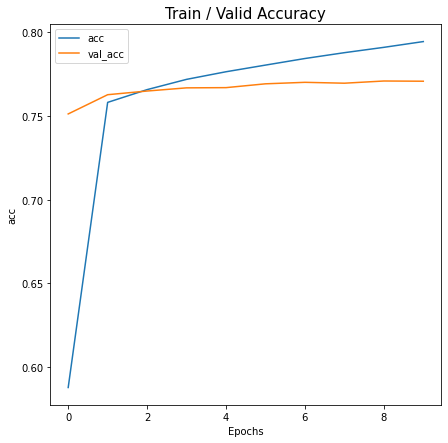

227/227 [==============================] - 17s 74ms/step - loss: 0.4887 - acc: 0.7689
[0.48874253034591675, 0.7688879370689392]
[0.7618480781018201]
[0.7857836579868428]
[0.7393275862068965]


In [ ]:
result = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[es,cp])
draw_plot(result, 'acc') 
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, batch_size=128)

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))
print(model.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

In [ ]:
# ML Models : SVM, RF, NB, XGB 적용

classifier_svm = SVC(C=1.0, kernel='linear', max_iter=10, random_state=my_seed)
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=my_seed)
nb = GaussianNB()
xgb = XGBClassifier(n_estimators=10, tree_method='gpu_hist')

In [ ]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf =  recall_score(y_test, y_pred_rf)

print('Accuracy : ', np.round(acc_rf,4))
print('F1-Score : ', np.round(f1_rf,4))
print('Precision : ', np.round(precision_rf,4))
print('Recall : ', np.round(recall_rf,4))

Accuracy :  0.7357
F1-Score :  0.7231
Precision :  0.7593
Recall :  0.6903


In [ ]:
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb =  recall_score(y_test, y_pred_nb)

print('Accuracy : ', np.round(acc_nb,4))
print('F1-Score : ', np.round(f1_nb,4))
print('Precision : ', np.round(precision_nb,4))
print('Recall : ', np.round(recall_nb,4))

Accuracy :  0.5924
F1-Score :  0.3462
Precision :  0.8744
Recall :  0.2158


In [ ]:
classifier_svm.fit(X_train, y_train)

y_pred_svm = classifier_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm =  recall_score(y_test, y_pred_svm)

print('Accuracy : ', np.round(acc_svm,4))
print('F1-Score : ', np.round(f1_svm,4))
print('Precision : ', np.round(precision_svm,4))
print('Recall : ', np.round(recall_svm,4))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Accuracy :  0.5007
F1-Score :  0.6667
Precision :  0.5003
Recall :  0.9987


In [ ]:
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb =  recall_score(y_test, y_pred_xgb)

print('Accuracy : ', np.round(acc_xgb,4))
print('F1-Score : ', np.round(f1_xgb,4))
print('Precision : ', np.round(precision_xgb,4))
print('Recall : ', np.round(recall_xgb,4))

Accuracy :  0.7558
F1-Score :  0.7567
Precision :  0.7539
Recall :  0.7595


# 모델 성능 비교 : ACC / Precision / Recall / F1-Score
* CNN-1D : 0.7569 / 0.7568 / 0.7572 / 0.7570
* LSTM : 0.7708 / 0.7777 / 0.7585 / 0.7680
* CNN-LSTM : 0.7638 / 0.7720 / 0.7488 / 0.7602
* RF :
* SVM : 0.4987 / 0.4993 / 0.9936 / 0.6646
* NB : 0.5924 / 0.8744 / 0.2158 / 0.3462
* XGB : 
